In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = list(range(10))
branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.5385385385385385, 1), ((0, 1, 2, 3, 4, 6, 8, 9), 0.5355355355355356, 0.5385385385385385), ((0, 1, 2, 3, 4, 6, 8), 0.48848848848848847, 0.5355355355355356), ((0, 1, 2, 3, 4, 6), 0.4854854854854855, 0.48848848848848847), ((1, 3), 0.4804804804804805, 0.4854854854854855), ((5, 7), 0.4314314314314314, 0.5385385385385385), ((0, 2, 4, 6), 0.4074074074074074, 0.4854854854854855), ((0, 6), 0.3943943943943944, 0.4074074074074074), ((2, 4), 0, 0.4074074074074074), ((9,), 0, 0.5355355355355356), ((8,), 0, 0.48848848848848847), ((1,), 0, 0.4804804804804805), ((3,), 0, 0.4804804804804805), ((5,), 0, 0.4314314314314314), ((7,), 0, 0.4314314314314314), ((6,), 0, 0.3943943943943944), ((0,), 0, 0.3943943943943944), ((4,), 0, 0), ((2,), 0, 0)]

dataset = torchvision.datasets.FashionMNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [4]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Create the model

In [5]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)

t_limit = 1
model = image_unet.MultitaskMNISTUNetTimeConcat(
    len(branch_defs), t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/fmnist_continuous"

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

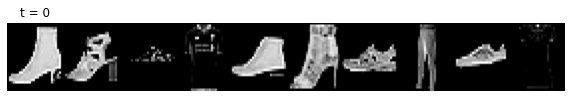

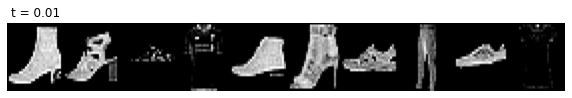

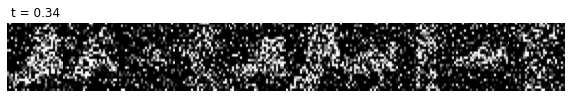

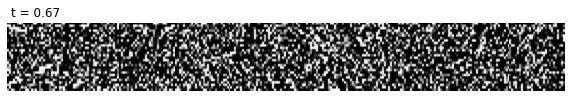

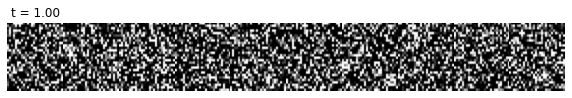

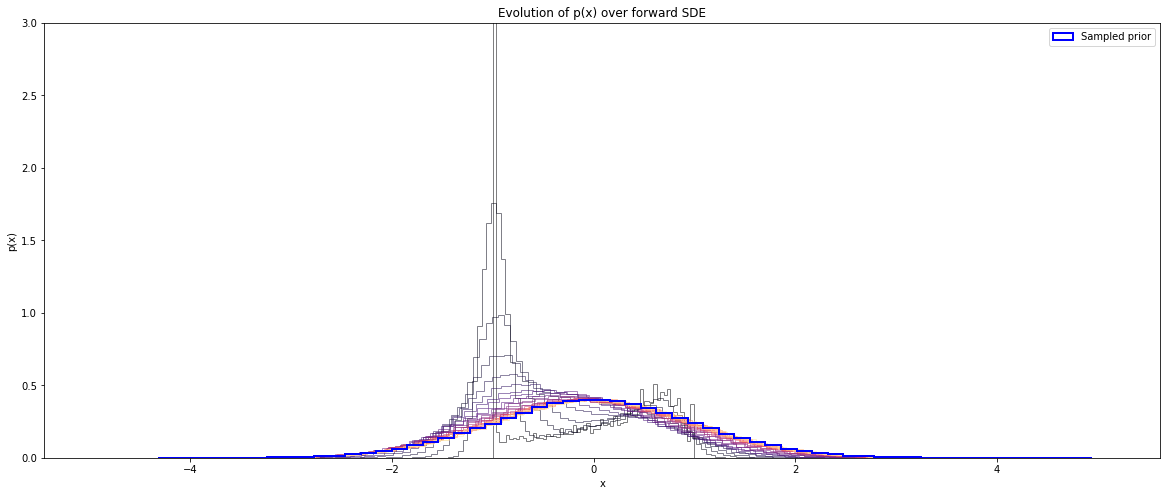

In [6]:
# Show some images after running the SDE forward for different times
time_steps = 4

x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()

plot_mnist_digits(x0, grid_size=(10, 1), title="t = 0")
x0 = torch.tensor(x0).to(DEVICE)
for t in np.linspace(0.01, t_limit, time_steps):
    xt, score = sde.forward(x0, torch.full(x0.shape[:1], t).to(DEVICE))
    plot_mnist_digits(xt.cpu().numpy(), grid_size=(10, 1), title=("t = %.2f" % t))
    
# Show the transformation of the distribution of data to the prior distribution
time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [ ]:
train_continuous_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 120,
        "learning_rate": 0.001,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "1"
Loss: 87.76: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:53<00:00,  4.14it/s]


Epoch 1 average Loss: 191.52


Loss: 59.15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:28<00:00,  5.32it/s]


Epoch 2 average Loss: 85.79


Loss: 58.25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:28<00:00,  5.32it/s]


Epoch 3 average Loss: 71.81


Loss: 63.52: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:28<00:00,  5.28it/s]


Epoch 4 average Loss: 66.06


Loss: 59.70: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:29<00:00,  5.22it/s]


Epoch 5 average Loss: 61.89


Loss: 41.51: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:29<00:00,  5.22it/s]


Epoch 6 average Loss: 58.85


Loss: 58.15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:31<00:00,  5.11it/s]


Epoch 7 average Loss: 56.88


Loss: 50.73: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:28<00:00,  5.31it/s]


Epoch 8 average Loss: 55.05


Loss: 37.15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:28<00:00,  5.31it/s]


Epoch 9 average Loss: 54.32


Loss: 49.05: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:31<00:00,  5.13it/s]


Epoch 10 average Loss: 53.13


Loss: 38.02: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:28<00:00,  5.33it/s]


Epoch 11 average Loss: 51.99


Loss: 43.75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:28<00:00,  5.31it/s]


Epoch 12 average Loss: 51.33


Loss: 50.47: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:28<00:00,  5.28it/s]


Epoch 13 average Loss: 50.20


Loss: 58.43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:28<00:00,  5.30it/s]


Epoch 14 average Loss: 49.82


Loss: 61.67: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:28<00:00,  5.30it/s]


Epoch 15 average Loss: 48.85


Loss: 32.34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:29<00:00,  5.25it/s]


Epoch 16 average Loss: 48.86


Loss: 54.35:  43%|████████████████████████████████████████████▊                                                            | 200/469 [00:38<00:50,  5.31it/s]

### Show generated digits

In [ ]:
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit
    )
    plot_mnist_digits(samples.cpu().numpy(), grid_size=(10, 1), title=None)